In this demo, I will show you how to make distributed design experiments on a public-cloud multi-node Kubernetes cluster.

We assume that (1) a Kubernetes cluster is running on IBM Cloud, and (2) we have installed IBM Cloud CLI on our laptop.

* IBM Cloud CLI installation: https://cloud.ibm.com/docs/cli?topic=cli-getting-started

# Kubernetes Cluster Setup (IBM Cloud)

---
## Cluster Installation

We use our own Kubernetes cluster running on IBM Cloud.

First, let us check whether we can access it from our laptop.
The command below will show us available Kubernetes clusters on IBM Cloud.

In [1]:
!ibmcloud ks cluster ls

OK
Name              ID                     State    Created      Workers   Location   Version       Resource Group Name   Provider   
rdf-k8s-cluster   c7e46qfd07mhn77qkij0   normal   4 days ago   3         Dallas     1.21.7_1541   Default               classic   


<br/>

Now, we install cluster information in our local machine.

The following command downloads the cluster information from IBM Cloud, and make it usable from our laptop.

In [2]:
!ibmcloud ks cluster config -c rdf-k8s-cluster

OK
The configuration for rdf-k8s-cluster was downloaded successfully.

Added context for rdf-k8s-cluster to the current kubeconfig file.
You can now execute 'kubectl' commands against your cluster. For example, run 'kubectl get nodes'.
If you are accessing the cluster for the first time, 'kubectl' commands might fail for a few seconds while RBAC synchronizes.


<br/>

Now, check whether the Kubernetes cluster is activated on the local machine or not.

In [3]:
!kubectl config current-context

rdf-k8s-cluster/c7e46qfd07mhn77qkij0


<br/>
Check the Kubernetes nodes.

In [4]:
!kubectl get nodes

NAME           STATUS   ROLES    AGE   VERSION
10.177.62.15   Ready    <none>   4d    v1.21.7+IKS
10.177.62.16   Ready    <none>   4d    v1.21.7+IKS
10.177.62.19   Ready    <none>   4d    v1.21.7+IKS


---
## Namespace and Volume

We create a namespace as we did in the previous demos.

In [5]:
!kubectl apply -f rdf-namespace.yaml
!kubectl get namespaces

namespace/rdf created
NAME              STATUS   AGE
default           Active   4d1h
ibm-cert-store    Active   4d
ibm-operators     Active   4d1h
ibm-system        Active   4d1h
kube-node-lease   Active   4d1h
kube-public       Active   4d1h
kube-system       Active   4d1h
rdf               Active   0s


<br/>

We now create a volume which we use as workspace.
Different from previous examples, we use **cloud storages** this time since we use public cloud service.

Each cloud provider has different mechanism for storage provisioning.

* The YAML file below shows an example for IBM Cloud.
* It provisions a 20GB storage, and create Persistent Volume and Persistent Volume Claim.

```yaml
# pvc-ibm-cloud.yaml
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: rdf-workspace-pv-claim
  namespace: rdf
  labels:
    billingType: "hourly"
    region: us-south
    zone: dal10 # Set the zone same as your cluster zone
spec:
  accessModes:
    - ReadWriteMany
  resources:
    requests:
      storage: 20Gi
  storageClassName: ibmc-file-silver
```

Save the above YAML file, and apply it via `kubectl apply`.

In [6]:
!kubectl apply -f pvc-ibm-cloud.yaml

persistentvolumeclaim/rdf-workspace-pv-claim created


<br/>
Check the created volume.

In [7]:
!kubectl -n rdf get pvc rdf-workspace-pv-claim

NAME                     STATUS   VOLUME                                     CAPACITY   ACCESS MODES   STORAGECLASS       AGE
rdf-workspace-pv-claim   Bound    pvc-e8201fb5-312f-43ae-8d89-c5f27e781d74   20Gi       RWX            ibmc-file-silver   2m52s


---
## Upload Files to Volume

As the storage is on IBM Cloud, we have to transfer the necessary files for our experiments. There are multiple ways depending on the cloud providers.

Here, we use a cloud-agnostic way to transfer files, using only `kubectl` commands:

1. Create a minimal linux pod, mounting the persistent volume.
1. Use `kubectl cp` command to transfer local files to the pod, with the destination path to the persistent volume.

In [8]:
# 1. Create a minimal linux pod
!kubectl apply -f pod-alpine.yaml
!kubectl -n rdf get pod

pod/alpine created
NAME     READY   STATUS    RESTARTS   AGE
alpine   1/1     Running   0          6s


In [9]:
# 2. Copy the local files to the pod (path: mounted persistent volume)
!kubectl -n rdf cp workspace_files.tgz alpine:/workspace --no-preserve=true
!kubectl -n rdf exec alpine -- \
    sh -c "cd /workspace; tar xvfz workspace_files.tgz; rm workspace_files.tgz"

experiment-template/
experiment-template/gcd.v
experiment-template/Makefile
experiment-template/constraint.sdc
experiment-template/config.mk
experiment-template/.gitignore
openroad-flow/
openroad-flow/platforms/
openroad-flow/util/
openroad-flow/Makefile
openroad-flow/scripts/
openroad-flow/scripts/generate_lef.tcl
openroad-flow/scripts/generate_abstract.tcl
openroad-flow/scripts/detail_place.tcl
openroad-flow/scripts/resize.tcl
openroad-flow/scripts/global_route.tcl
openroad-flow/scripts/cdl.tcl
openroad-flow/scripts/tapcell.tcl
openroad-flow/scripts/yosys.tcl
openroad-flow/scripts/view_cells.tcl
openroad-flow/scripts/io_placement.tcl
openroad-flow/scripts/cts.tcl
openroad-flow/scripts/run_all.tcl
openroad-flow/scripts/synth_preamble.tcl
openroad-flow/scripts/abc_area.script
openroad-flow/scripts/deleteNonClkNets.tcl
openroad-flow/scripts/add_routing_blk.tcl
openroad-flow/scripts/global_place.tcl
openroad-flow/scripts/gui.tcl
openroad-flow/scripts/read_macro_placement.tcl
openroad-flo

<br />
Check the file transfer result.

In [10]:
!kubectl -n rdf exec alpine -- sh -c "ls -l /workspace"

total 8
drwxr-xr-x    2 501      dialout       4096 Jan 14 15:57 experiment-template
drwxr-xr-x    5 501      dialout       4096 Jan 14 15:56 openroad-flow


---

## Pods

We create pods.

We use the same commands as in the previous, single-node Ray example, except the number of workers. We create **8 Ray workers** (1 head + 7 workers) this time, each with 2 CPUs available.

In [11]:
!helm -n rdf install rdf-ray-cluster ./rdf-ray \
    --set podTypes.rayWorkerType.maxWorkers=7 \
    --set podTypes.rayWorkerType.minWorkers=7 \
    --set podTypes.rayHeadType.CPU=2 \
    --set podTypes.rayWorkerType.CPU=2

NAME: rdf-ray-cluster
LAST DEPLOYED: Fri Jan 14 10:58:27 2022
NAMESPACE: rdf
STATUS: deployed
REVISION: 1
TEST SUITE: None


Now, we check the deployed pods. You will see 8 RDF pods available in the cluster.

In [12]:
!kubectl -n rdf get all

NAME                                        READY   STATUS    RESTARTS   AGE
pod/alpine                                  1/1     Running   0          5m10s
pod/rdf-ray-cluster-ray-head-type-ljv2c     1/1     Running   0          22s
pod/rdf-ray-cluster-ray-worker-type-bn4hb   1/1     Running   0          9s
pod/rdf-ray-cluster-ray-worker-type-d6l7s   1/1     Running   0          9s
pod/rdf-ray-cluster-ray-worker-type-gdbwj   1/1     Running   0          9s
pod/rdf-ray-cluster-ray-worker-type-p5428   1/1     Running   0          9s
pod/rdf-ray-cluster-ray-worker-type-w5tzm   1/1     Running   0          9s
pod/rdf-ray-cluster-ray-worker-type-xsnct   1/1     Running   0          9s
pod/rdf-ray-cluster-ray-worker-type-zzpw8   1/1     Running   0          9s

NAME                               TYPE        CLUSTER-IP      EXTERNAL-IP   PORT(S)                       AGE
service/rdf-ray-cluster-ray-head   ClusterIP   172.21.77.165   <none>        10001/TCP,8265/TCP,8000/TCP   23s


---
## Networking


Now, expose a network port so that Ray can distribute jobs across the pods.

```bash
POD=$(kubectl -n rdf get pod -l ray-node-type=head --output=jsonpath={.items..metadata.name})
kubectl -n rdf port-forward $POD 10001
```

---

## Summary

Our Kubernetes cluster now has:
    
* **3 nodes**, each with 8 CPUs.
* **1 storage** on cloud, having design collateral and PDK/libraries.
* **8 pods**, each running DATC RDF container.
* **Ray** is enabled to distribute jobs on 8 pods.

<img src="./figs/k8s-multi-node-ray.png" alt="k8s-multi-node-ray" width="90%"/>

---
# Distributing Tasks with Ray

As we have done in the single-node Ray Kubernetes Cluster, we use Python API for Ray initialization.

In [13]:
import ray
ray.init("ray://localhost:10001")

ClientContext(dashboard_url=None, python_version='3.9.6', ray_version='1.9.1', ray_commit='2cdbf974ea63caf4323aacbccaef2394a14a8562', protocol_version='2021-09-22', _num_clients=1, _context_to_restore=<ray.util.client._ClientContext object at 0x1113ab0d0>)

<br/>
And we check the available resources as follows.

In [14]:
ray.available_resources()

{'node:172.30.238.98': 1.0,
 'node:172.30.238.99': 1.0,
 'memory': 24051816856.0,
 'CPU': 16.0,
 'node:172.30.233.87': 1.0,
 'node:172.30.233.86': 1.0,
 'node:172.30.235.25': 1.0,
 'object_store_memory': 10193541031.0,
 'node:172.30.235.24': 1.0,
 'node:172.30.238.100': 1.0,
 'node:172.30.235.26': 1.0}

---

## Testing Ray on Kubernetes Cluster

First, let us test whether Ray distributs tasks in different pods using a simple task.

In [15]:
import socket

@ray.remote(num_cpus=2)
def test_ray(x):
    # Wait 1 second.
    import time
    time.sleep(1)
    print("Job {} -- Done (host: {})".format(x+1, socket.gethostname()))

<br/>

We **invoke the function 30 times**, and see whether Ray distributes it.

In [16]:
obj_refs = [test_ray.remote(i) for i in range(30)]

# Wait until finished
while True:
    ready_refs, remaining_refs = ray.wait(obj_refs)
    if len(remaining_refs) == 0:
        break
    obj_refs = remaining_refs

print("Done.")

(test_ray pid=238) Job 1 -- Done (host: rdf-ray-cluster-ray-head-type-ljv2c)
(test_ray pid=127, ip=172.30.238.98) Job 2 -- Done (host: rdf-ray-cluster-ray-worker-type-zzpw8)
(test_ray pid=125, ip=172.30.238.99) Job 3 -- Done (host: rdf-ray-cluster-ray-worker-type-gdbwj)
(test_ray pid=238) Job 4 -- Done (host: rdf-ray-cluster-ray-head-type-ljv2c)
(test_ray pid=125, ip=172.30.238.100) Job 5 -- Done (host: rdf-ray-cluster-ray-worker-type-p5428)
(test_ray pid=238) Job 7 -- Done (host: rdf-ray-cluster-ray-head-type-ljv2c)
(test_ray pid=129, ip=172.30.233.87) Job 6 -- Done (host: rdf-ray-cluster-ray-worker-type-bn4hb)
(test_ray pid=127, ip=172.30.238.98) Job 8 -- Done (host: rdf-ray-cluster-ray-worker-type-zzpw8)
(test_ray pid=125, ip=172.30.238.99) Job 10 -- Done (host: rdf-ray-cluster-ray-worker-type-gdbwj)
(test_ray pid=128, ip=172.30.235.26) Job 9 -- Done (host: rdf-ray-cluster-ray-worker-type-w5tzm)
(test_ray pid=125, ip=172.30.238.100) Job 13 -- Done (host: rdf-ray-cluster-ray-worker-t

---

## Running Distributed Design Flow Experiment 

We assume the same scenario as in the previous demo: our goal is to **find a maximum achivable utilization for a given design.**

So what we do is:

* Write a function that describes design flow modification and execution.
    1. Copy experiment template (design file, scripts, etc.)
    2. Modify the flow, i.e., change utilization
    3. Execute the flow.
* Put Ray decorator `@ray.remote(...)` at the function definition.

In [17]:
import socket
import subprocess

@ray.remote(num_cpus=2)
def sweep_utilization(util):
    print("FP util {} -- Running at {}".format(util, socket.gethostname()))

    # 1. Copy experiment template
    template = "/workspace/experiment-template"
    workspace = "/workspace/experiment-{}".format(util)
    subprocess.call("cp -r {} {}".format(template, workspace), shell=True)
    
    # 2. Change the utilization.
    with open("{}/config.mk".format(workspace), 'a') as f:
        f.write("\n# Experiment setup:\n")
        f.write("export CORE_UTILIZATION = {}\n".format(util))
    
    # 3. Execute the flow
    subprocess.call("cd {} && make DESIGN_CONFIG=./config.mk".format(workspace), 
                    stdout=subprocess.DEVNULL,
                    shell=True)
    
    print("FP util {} -- Done.".format(util))

<br/>

Now, we run the experiments.

* In this demo, I set the min/max utilization as **40%/60% with 1% step**.
* So, the experiments will run 21 times, each with different utilization.

In [18]:
# Min/Max utilization: 40%/60% (step: 1%)
obj_refs = [sweep_utilization.remote(util) for util in range(40, 61, 1)]

while True:
    ready_refs, remaining_refs = ray.wait(obj_refs)
    if len(remaining_refs) == 0:
        break
    obj_refs = remaining_refs

print("Experiment done.")

(sweep_utilization pid=125, ip=172.30.238.99) FP util 42 -- Running at rdf-ray-cluster-ray-worker-type-gdbwj
(sweep_utilization pid=126, ip=172.30.233.86) FP util 46 -- Running at rdf-ray-cluster-ray-worker-type-xsnct
(sweep_utilization pid=129, ip=172.30.233.87) FP util 44 -- Running at rdf-ray-cluster-ray-worker-type-bn4hb
(sweep_utilization pid=125, ip=172.30.238.100) FP util 43 -- Running at rdf-ray-cluster-ray-worker-type-p5428
(sweep_utilization pid=127, ip=172.30.238.98) FP util 41 -- Running at rdf-ray-cluster-ray-worker-type-zzpw8
(sweep_utilization pid=128, ip=172.30.235.25) FP util 47 -- Running at rdf-ray-cluster-ray-worker-type-d6l7s
(sweep_utilization pid=128, ip=172.30.235.26) FP util 45 -- Running at rdf-ray-cluster-ray-worker-type-w5tzm
(sweep_utilization pid=238) FP util 40 -- Running at rdf-ray-cluster-ray-head-type-ljv2c
(sweep_utilization pid=128, ip=172.30.235.25) FP util 47 -- Done.
(sweep_utilization pid=128, ip=172.30.235.25) FP util 48 -- Running at rdf-ray-cl

(sweep_utilization pid=128, ip=172.30.235.26) make: *** [Makefile:465: results/sky130hd/gcd/base/3_1_place_gp.def] Error 1


(sweep_utilization pid=129, ip=172.30.233.87) FP util 59 -- Done.


(sweep_utilization pid=129, ip=172.30.233.87) make: *** [Makefile:465: results/sky130hd/gcd/base/3_1_place_gp.def] Error 1
(sweep_utilization pid=128, ip=172.30.235.25) make: *** [Makefile:465: results/sky130hd/gcd/base/3_1_place_gp.def] Error 1


(sweep_utilization pid=128, ip=172.30.235.25) FP util 57 -- Done.
(sweep_utilization pid=238) FP util 60 -- Done.


(sweep_utilization pid=238) make: *** [Makefile:465: results/sky130hd/gcd/base/3_1_place_gp.def] Error 1


Experiment done.(sweep_utilization pid=126, ip=172.30.233.86) FP util 56 -- Done.



---
# Clean-Up Resources

We clean-up the Kubernetes cluster resources.

We first shutdown Ray.

In [19]:
ray.shutdown()

<br />

Our data is still in cloud. So, before cleaning-up the resources, we download the data to our local machine.

We use `kubectl cp` command here.

In [20]:
# kubectl -n <namespace> cp <source> <destination>
!kubectl -n rdf cp alpine:/workspace ./rdf-k8s-cluster-workspace --no-preserve=true

tar: removing leading '/' from member names


<br />

And check the downloaded files.

In [21]:
!ls rdf-k8s-cluster-workspace

experiment-40  experiment-45  experiment-50  experiment-55  experiment-60
experiment-41  experiment-46  experiment-51  experiment-56  experiment-template
experiment-42  experiment-47  experiment-52  experiment-57  openroad-flow
experiment-43  experiment-48  experiment-53  experiment-58
experiment-44  experiment-49  experiment-54  experiment-59


<br />

We now delete all the resources by the following command, same as in the previous demo.

In [22]:
!kubectl -n rdf delete raycluster rdf-ray-cluster
!helm -n rdf uninstall rdf-ray-cluster
!kubectl delete -f ./pvc-ibm-cloud.yaml
!kubectl delete -f rdf-namespace.yaml

raycluster.cluster.ray.io "rdf-ray-cluster" deleted
release "rdf-ray-cluster" uninstalled
persistentvolumeclaim "rdf-workspace-pv-claim" deleted
namespace "rdf" deleted


<br />

Also, **be aware that public cloud is not free.**
So, when you don't need the cluster any more, delete the cluster completely. 

In IBM Cloud, you can use the following command:

```bash
ibmcloud ks cluster rm --cluster <your-cluster-name>
```

---
# Analyze Results

We now check results and find the maximum achivable utilization for the design.

We use the same scripts as in the previous demo.

In [24]:
for util in range(40, 61):
    workspace = "rdf-k8s-cluster-workspace/experiment-{}/logs/sky130hd/gcd/base".format(util)
    with open('{}/3_1_place_gp.log'.format(workspace)) as f:
        lines = [l for l in [_.strip() for _ in f] if l]

    for l in lines:
        if l.startswith("[ERROR GPL-0302]"):    
            print("Floorplan utilization {}%: Unachievable".format(util))
            continue
    try:
        with open('{}/6_report.log'.format(workspace)) as f:
            lines = [l for l in [_.strip() for _ in f] if l]
    except FileNotFoundError:
        continue
    
    for l in lines:
        if l.startswith("Design area"):    
            print("Floorplan utilization {}%: {}".format(util,l))

Floorplan utilization 40%: Design area 2719 u^2 53% utilization.
Floorplan utilization 41%: Design area 2674 u^2 55% utilization.
Floorplan utilization 42%: Design area 2750 u^2 57% utilization.
Floorplan utilization 43%: Design area 2645 u^2 56% utilization.
Floorplan utilization 44%: Design area 2693 u^2 60% utilization.
Floorplan utilization 45%: Design area 3025 u^2 68% utilization.
Floorplan utilization 46%: Design area 2805 u^2 64% utilization.
Floorplan utilization 47%: Design area 2675 u^2 61% utilization.
Floorplan utilization 48%: Design area 2600 u^2 63% utilization.
Floorplan utilization 49%: Design area 2660 u^2 65% utilization.
Floorplan utilization 50%: Design area 2634 u^2 65% utilization.
Floorplan utilization 51%: Design area 2801 u^2 70% utilization.
Floorplan utilization 52%: Design area 2659 u^2 70% utilization.
Floorplan utilization 53%: Design area 2586 u^2 69% utilization.
Floorplan utilization 54%: Design area 2724 u^2 73% utilization.
Floorplan utilization 55%

<br/>

We can also check the layout images to see whether the experiments ran properly or not.

The script below plots all the layout images generated.

<Figure size 432x288 with 0 Axes>

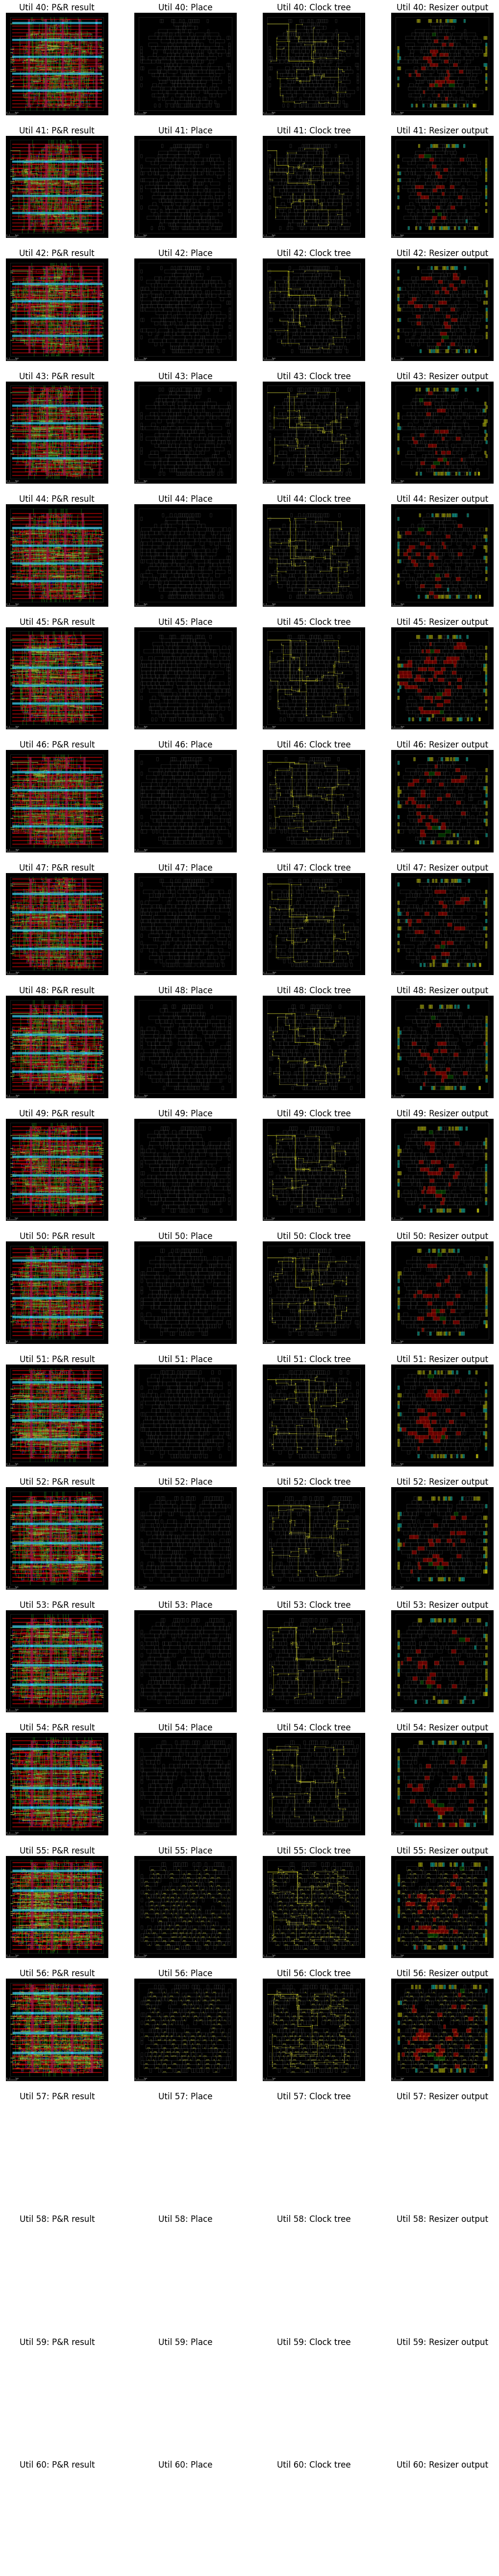

In [25]:
import webp
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

fig, axs = plt.subplots(21,4)
fig.set_size_inches(18,96)
[axi.set_axis_off() for axi in axs.ravel()]

for i in range(21):
    util = i + 40
    workspace = "rdf-k8s-cluster-workspace"
    report_dir = "{}/experiment-{}/reports/sky130hd/gcd/base".format(workspace, util)
    
    try:
        pnr = webp.load_image("{}/final.webp".format(report_dir))
        place = webp.load_image("{}/final_placement.webp".format(report_dir))
        clock = webp.load_image("{}/final_clocks.webp".format(report_dir))
        resize = webp.load_image("{}/final_resizer.webp".format(report_dir))

        axs[i][0].imshow(pnr)
        axs[i][1].imshow(place)
        axs[i][2].imshow(clock)
        axs[i][3].imshow(resize)
    except FileNotFoundError:
        pass
    
    axs[i][0].set_title("Util {}: P&R result".format(util))
    axs[i][1].set_title("Util {}: Place".format(util))
    axs[i][2].set_title("Util {}: Clock tree".format(util))
    axs[i][3].set_title("Util {}: Resizer output".format(util))